## V02

New model with V+^2 

Idea: Tune K based on Vmax from best-track and see if there is an evolution in the K time series over the database

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
# import functions as f
# import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
}

PTHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
}

### 1) SAR data

In [3]:
### OPEN DATA
dsg = xr.open_dataset(PTHS['ds_glob_path'])
dsg.where(dsg.storm_name == 'MARIE', drop=True).B_hol

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'B_hol' (time: 5)>
array([1.79940384, 2.37396689, 1.67238905, 1.78461914, 1.59906357])
Coordinates:
  * time     (time) datetime64[ns] 2020-10-02T02:23:31 ... 2020-10-04T14:29:05

In [4]:
### MARIE
p1    = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2    = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3    = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4    = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5    = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

p1dsg = 'rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc'
p2dsg = 'rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc'
p3dsg = 's1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc'
p4dsg = 'rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc'
p5dsg = 's1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc'

Text(0.5, 1.0, 'MARIE, EP182020')

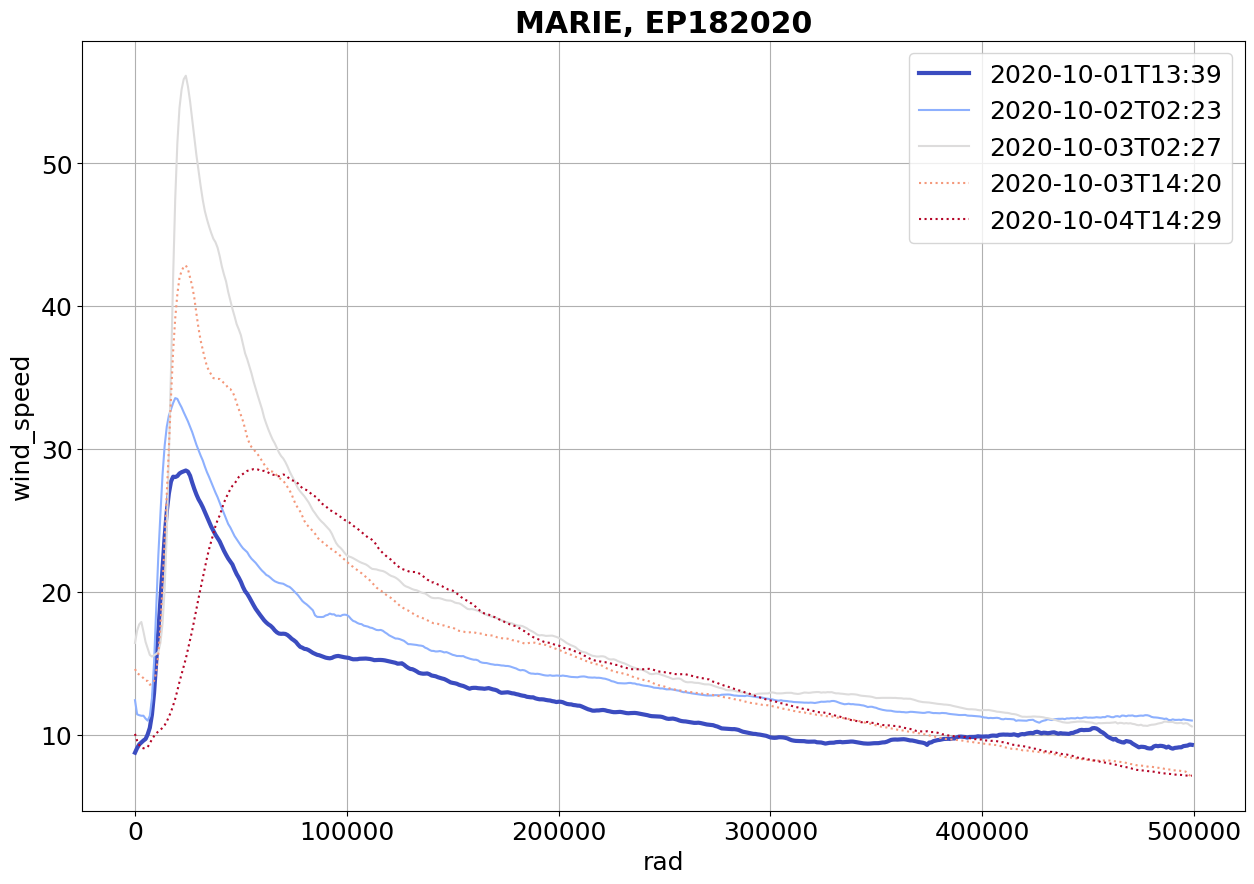

In [5]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

### 2) Functions and model

In [211]:
### FUNCTIONS

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

### Resolution
### Define dr accordingly (in vorticity() and N())
# -> 1 meter resolution
# rs = np.linspace(10, 500000, 499991)
# rs = np.linspace(10, 600000, 599991)
# dr = 1 # meters

# -> 10 meters resolution
# rs = np.linspace(10, 500000, 50000)
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters


def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def N(r, M):
    '''Rotational stability frequency'''
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

# def get_v(ds, fcor, L):
#     ws = ds.wind_speed.mean(dim='theta', skipna=True)
#     r = ws.rad / L
#     v = ws     / (fcor * L)

#     V = xr.DataArray(
#         data=v,
#         coords={'rad': r}
#     )
#     return V

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                  # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)}) # Inner-core: v0 interpolated on r * e^t
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))  # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})            # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)           # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})            # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def compute_lbda(r, V, fcor, R_plus, V_plus, gamma=1/20, Cd_plus=2e-3, K=10):
    M_abs = r * V + 0.5 * fcor * (r ** 2)
    M_rel = r * V
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # left  = float(Cd_plus * V_plus * R_plus) / (fcor * M)
        left  = gamma * float(Cd_plus * (V_plus ** 2) * R_plus) / (fcor * M_rel)
        right = np.sqrt(N(r, M_rel) / (2 * K))
        lbda  = left * right
        
    # # Plot
    # plt.plot(lbda)
    # plt.yscale('log')
    
    return np.array(lbda)

###################
### CHARAC TIME ###
###################

def compute_tau_recirculation(r, V, fcor):
    vmx = np.nanmax(V)
    rmx = r[np.nanargmax(V)]
    r0  = np.sqrt(2 * vmx / (fcor * rmx)) * rmx
    v0  = V[r >= r0][0]
    return (r0 / v0) / 3600

### 3) Apply model

In [8]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))

In [216]:
def MODEL(r, V_ini, fcors, HPRMS):
    # Colors
    clrs = mpl.cm.coolwarm_r(np.linspace(0, 1, HPRMS['n_steps'] + 1))
    
    # Initialization (a parametric profile, e.g Holland)
    V = V_ini
    
    # Iterations
    for t in tqdm(range(HPRMS['n_steps'])):
        # Plot
        plt.plot(r, V, c=clrs[t], linestyle='dashed')
        
        # Characteristic scales
        R_plus, V_plus = compute_RV_plus(r, V, fcors[t], PRMS['n'])
        print('R+ = {:.0f} km'.format(R_plus / 1000))
        L              = R_plus
        tau            = float(1 / fcors[t])

        # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
        V_hol = smooth_with_holland(r, V, fcors[t])
        lbda  = compute_lbda(r, V_hol, fcors[t], R_plus, V_plus, HPRMS['gamma'], HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
        # Normalize
        V_nrm = xr.DataArray(
            data=V / (fcors[t] * L),
            coords={'rad': r / L}
        )

        # Apply KK10
        V = v_k10(V_nrm, t=HPRMS['dt'], lbda=lbda) * fcors[t] * L # dimensional
        
    # Plot the last iteration
    plt.plot(r, V,  c=clrs[t + 1], linestyle='dashed', label='Analytical solution')
    
    return V

def interpolate_two_profiles(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K=20):
    ### Characteristic times
    # Tau model
    tau_ini = (1 / fcor_ini) / 3600 # hrs
    tau_fin = (1 / fcor_fin) / 3600 # hrs
    # Tau re-circulation
    tau2    = compute_tau_recirculation(r, VHS[str(i)], fcor_ini) # Compute R0/V0
    
    # Nb of steps 
    n_steps = int(np.ceil(delta_h / tau2))

    # Coriolis forces
    fcors   = np.linspace(fcor_ini, fcor_fin, n_steps)
    
    # Hyperparameters
    HPRMS = {
        'dt':      tau2 / tau_ini,               # non-dimensional time step
        'n_steps': n_steps, # hr, nb of iterations
        'gamma':   1/20,
        'K':       K,                            # m^2/s, diffusivity coefficient
        'Cd_plus': 2.5e-3,                       # [], drag coefficient, maximal at R+ (so shouldn't be tuned)
    }

    # Run model
    V = MODEL(r, V_ini, fcors, HPRMS)
    
    return None

In [49]:
np.tan(np.deg2rad(25))

0.4663076581549986

In [50]:
np.rad2deg(np.arctan(0.46))

24.702430227771313

In [163]:
np.rad2deg(np.arctan(1 / 4))

14.036243467926479

In [210]:
# V      = VHS[str(i)]
# fcor   = float(abs(coriolis(DS[str(i)].lat_center)))
# Rp, Vp = compute_RV_plus(rs, V, fcor, n=5)
# lbda   = compute_lbda(rs, V, fcor, Rp, Vp, gamma=1/20, Cd_plus=2e-3, K=20) # normalized by f

# M     = rs * V + 0.5 * fcor * rs ** 2
# u     = (fcor * Rp / Vp) * V
# lbda2 = u * np.gradient(np.log(M), dr) / fcor

# u     = V / 50
# lbda3 = u * np.gradient(np.log(M), dr) / fcor

# plt.plot(rs, lbda)
# plt.plot(rs, lbda2, c='red', linewidth=2)
# plt.plot(rs, lbda3, c='k', linewidth=2)
# plt.yscale('log');plt.grid()

  0%|          | 0/3 [00:00<?, ?it/s]

R+ = 58 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 53 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 51 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

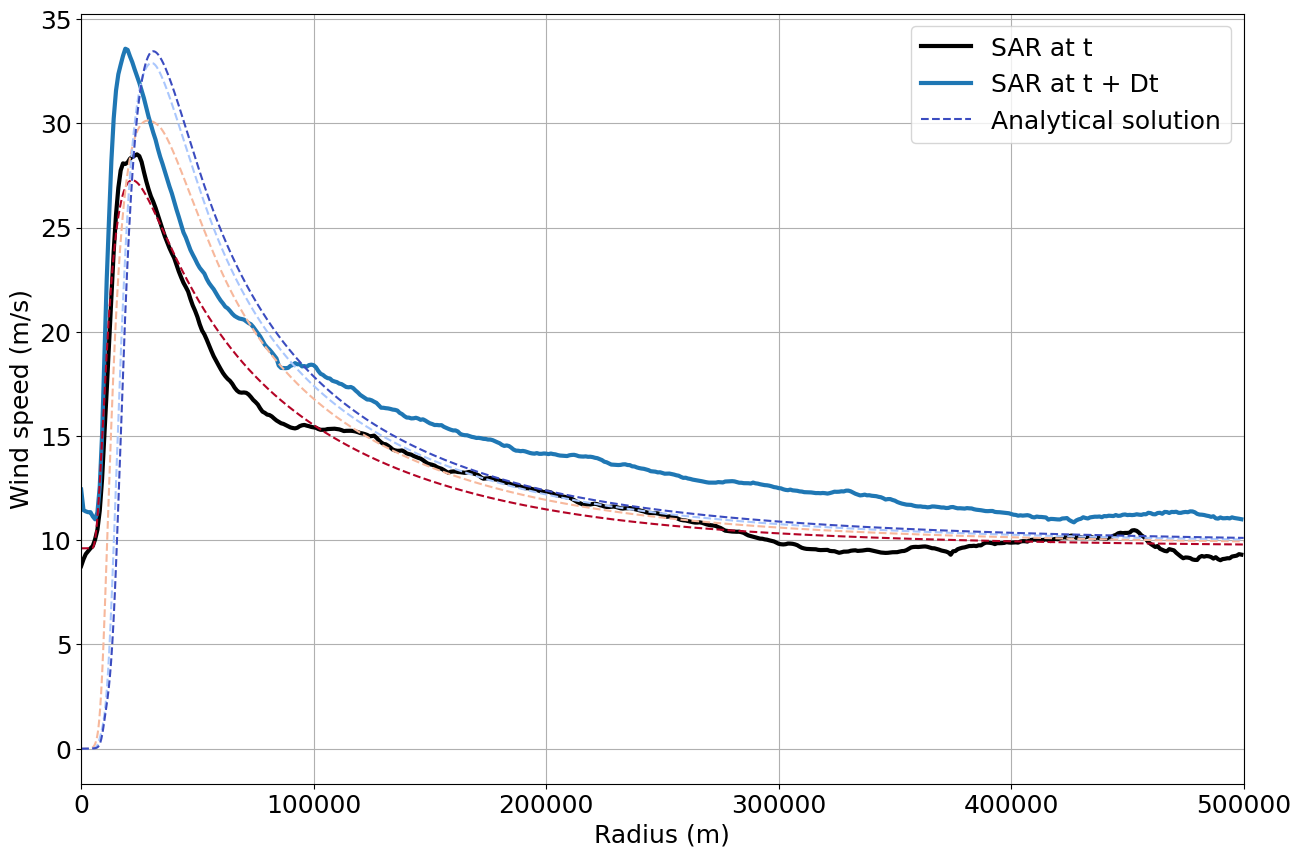

In [218]:
i       = 0
delta_h = 12
K       = 30

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

In [104]:
# V  = VHS[str(i)]
# M  = rs * V + 0.5 * float(coriolis(DS[str(i)].lat_center)) * (rs ** 2)
# dr = 10 # meters
# plt.plot(rs, np.gradient(M, dr))

In [105]:
# V = VHS[str(i)]
# M = rs * V + 0.5 * float(coriolis(DS[str(i)].lat_center)) * (rs ** 2)
# dr = 10 # meters
# q = (1 / M) * np.gradient(M, dr)
# plt.plot(rs, q)
# plt.yscale('log')

# # plt.plot(V)
# # dr = 10 # meters
#     # return (1 / r) * np.gradient(r * v, dr)

In [106]:
# V_plus_0 = 20
# DS[str(i)].cyclone_speed
# DS[str(i)].cyclone_speed * (DS[str(i)].Vmax_1D ** 2) / V_plus_0

  0%|          | 0/7 [00:00<?, ?it/s]

R+ = 62 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 55 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 50 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 48 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 47 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 47 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 48 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

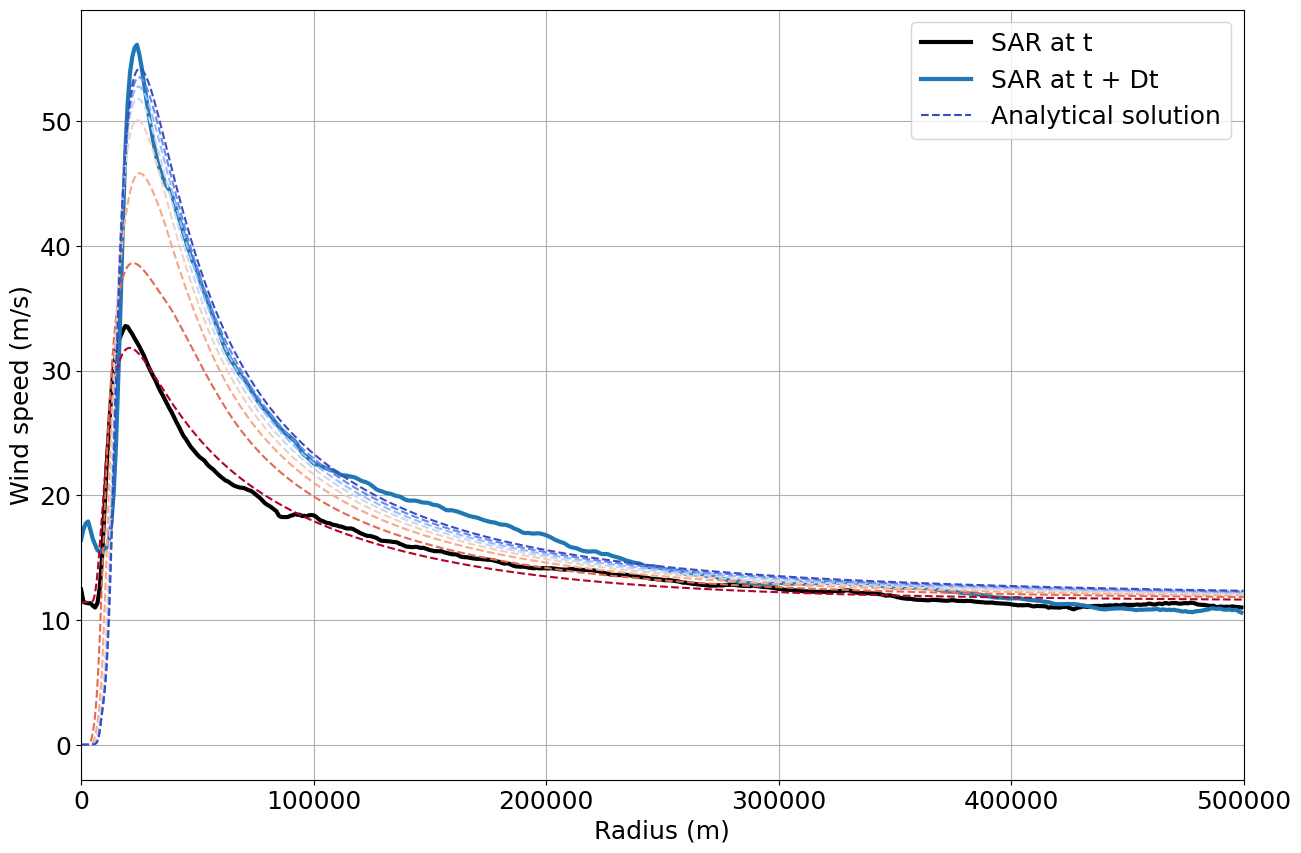

In [223]:
i       = 1
delta_h = 24
K       = 120
# K       = 50000

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/3 [00:00<?, ?it/s]

R+ = 52 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 55 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 57 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

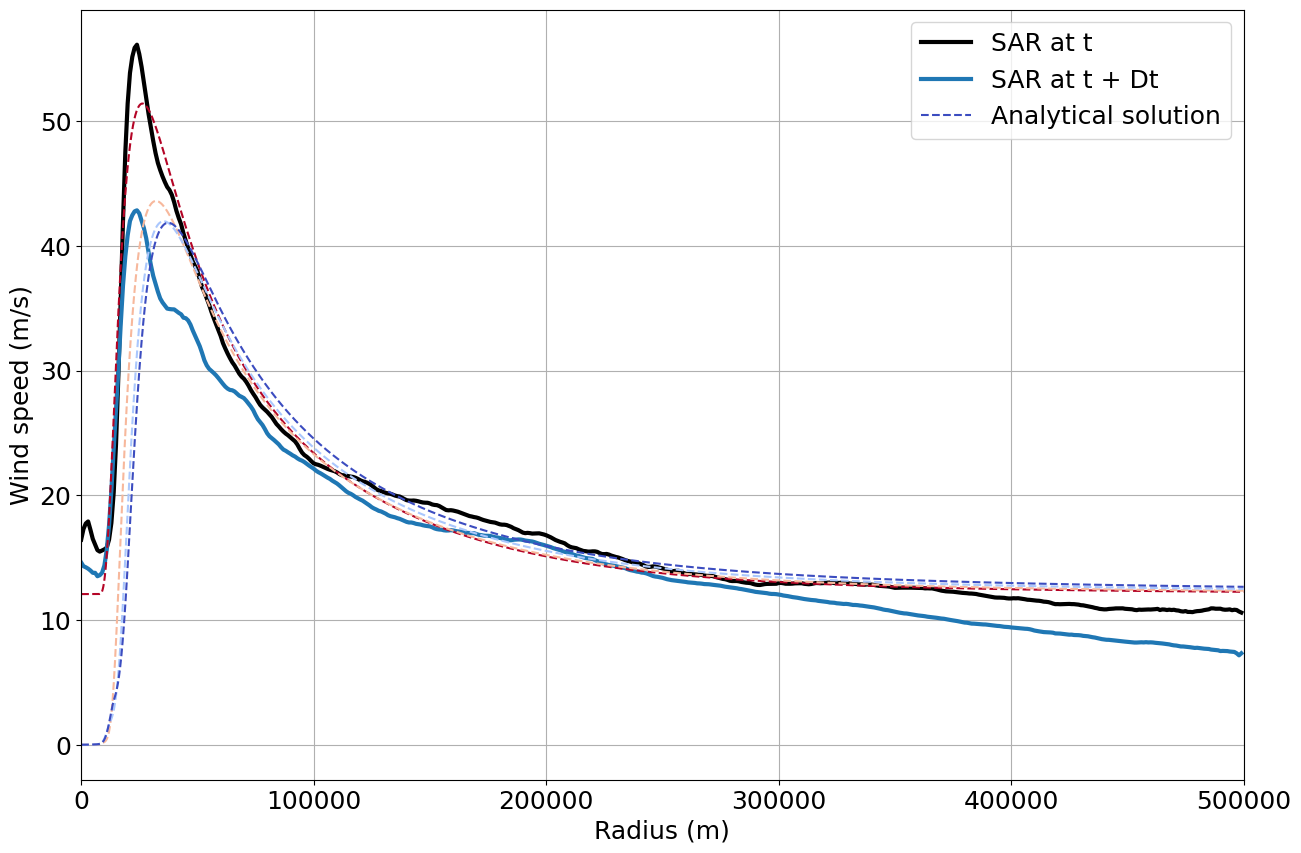

In [225]:
i       = 2
delta_h = 12
K       = 50
# K       = 22000

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/6 [00:00<?, ?it/s]

R+ = 62 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 66 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 68 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 70 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 72 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 73 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

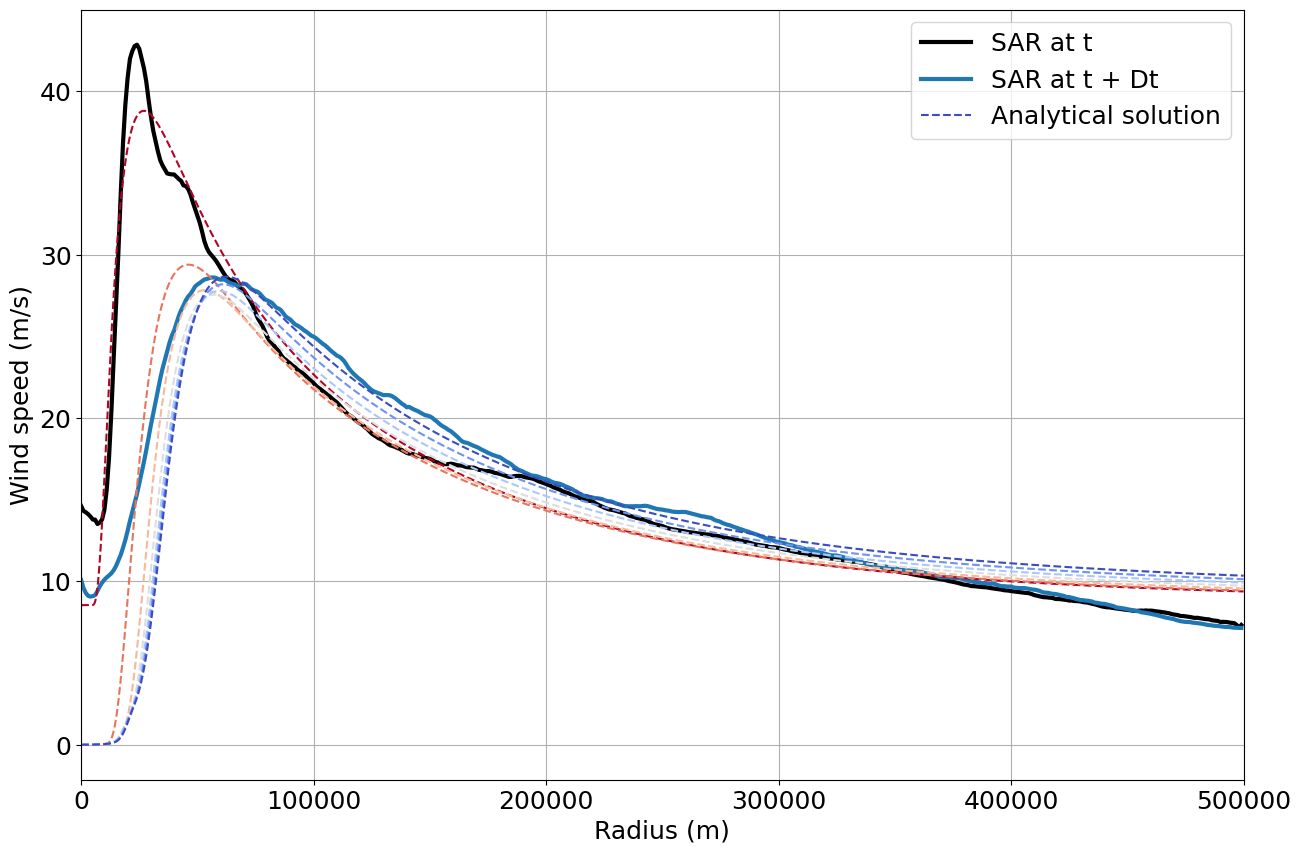

In [230]:
i       = 3
delta_h = 24
K       = 7

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

### Test: Hector 2018

Check also Lester.
Eventually, Soudelor, Habana?

Try Larry for Clement

In [16]:
dsg.where(dsg.storm_name == 'HECTOR', drop=True).sat_file.sortby('time')

<xarray.DataArray 'sat_file' (time: 9)>
array(['rs2--owi-cm-20120814t013918-20120814t014034-00003-52C09_sw.nc',
       'rs2--owi-cm-20180803t142144-20180803t142259-00003-0444B_sw.nc',
       'rs2--owi-cm-20180805t150354-20180805t150510-00003-05A2E_sw.nc',
       's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_sw.nc',
       'rs2--owi-cm-20180807t154512-20180807t154628-00003-07134_sw.nc',
       's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc',
       's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_sw.nc',
       's1b-ew-owi-cm-20180811t052613-20180811t052854-000003-0167F5_sw.nc',
       's1a-ew-owi-cm-20180812t172848-20180812t173053-000003-0285E5_sw.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-14T01:39:56 ... 2018-08-12T17:29:50

Text(0.5, 1.0, 'HECTOR, EP102018')

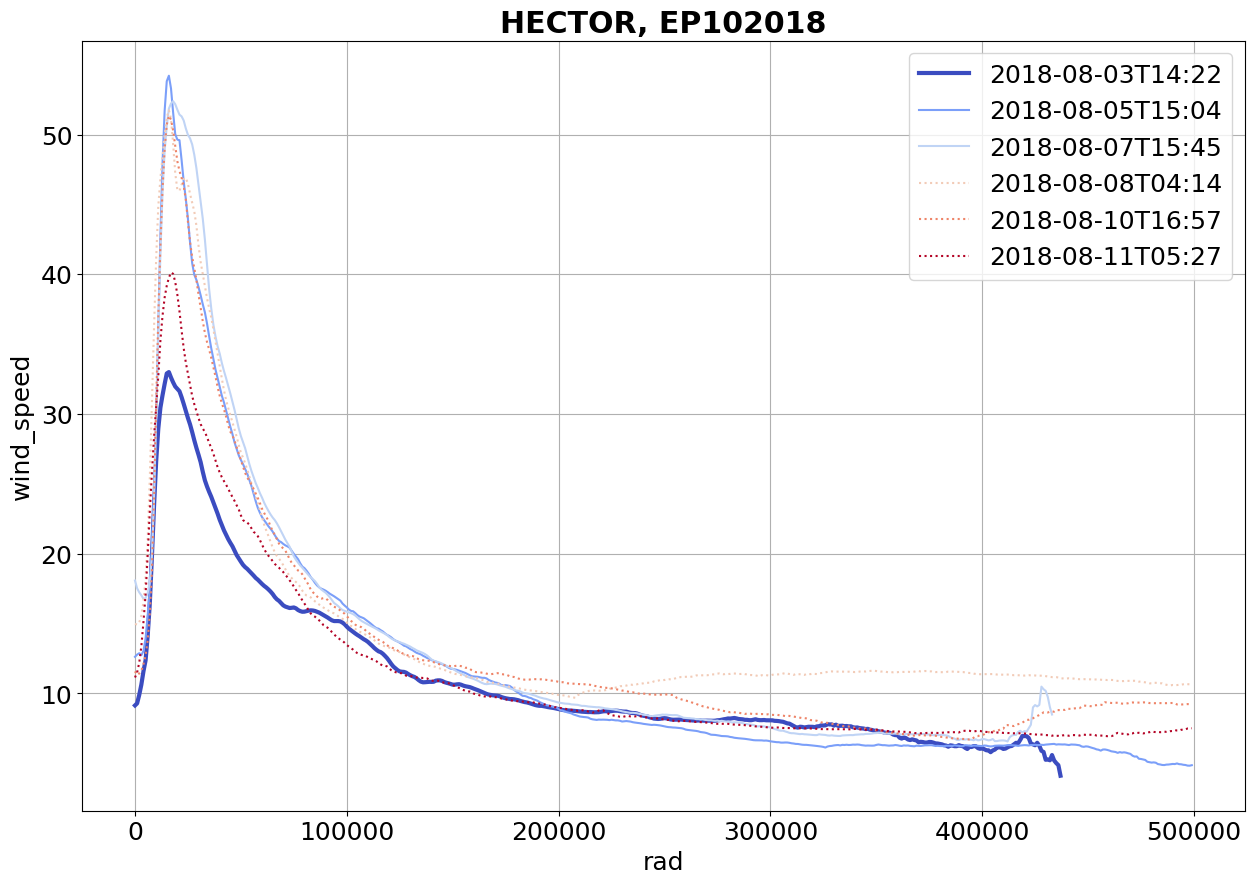

In [17]:
dsg.where(dsg.storm_name == 'HECTOR', drop=True).B_hol

### HECTOR
p1    = 'rs2--owi-ca-20180803t142144-20180803t142259-00003-0444B_sw_ep102018_cyclone.nc'
p2    = 'rs2--owi-ca-20180805t150354-20180805t150510-00003-05A2E_sw_ep102018_cyclone.nc'
p3    = 'rs2--owi-ca-20180807t154512-20180807t154628-00003-07134_sw_ep102018_cyclone.nc'
p4    = 's1a-ew-owi-ca-20180808t041303-20180808t041507-000003-0283BF_sw_ep102018_cyclone.nc'
p5    = 's1b-ew-owi-ca-20180810t165606-20180810t165822-000003-0167B7_sw_ep102018_cyclone.nc'
p6    = 's1b-ew-owi-ca-20180811t052613-20180811t052854-000003-0167F5_sw_ep102018_cyclone.nc'

p1dsg = 'rs2--owi-cm-20180803t142144-20180803t142259-00003-0444B_sw.nc'
p2dsg = 'rs2--owi-cm-20180805t150354-20180805t150510-00003-05A2E_sw.nc'
p3dsg = 'rs2--owi-cm-20180807t154512-20180807t154628-00003-07134_sw.nc'
p4dsg = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc'
p5dsg = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_sw.nc'
p6dsg = 's1b-ew-owi-cm-20180811t052613-20180811t052854-000003-0167F5_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 6))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)
ds6 = xr.open_dataset(PTHS['sar_dir'] + p6).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)
ws6 = ds6.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
ws6.plot(label='{}'.format(np.datetime_as_string(ds6.time, unit='m')), c=colors[5], linestyle='dotted')
plt.grid();plt.legend();plt.title('HECTOR, EP102018', weight='bold')

In [18]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg, p6dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))

  0%|          | 0/11 [00:00<?, ?it/s]

R+ = 50 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 45 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 41 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

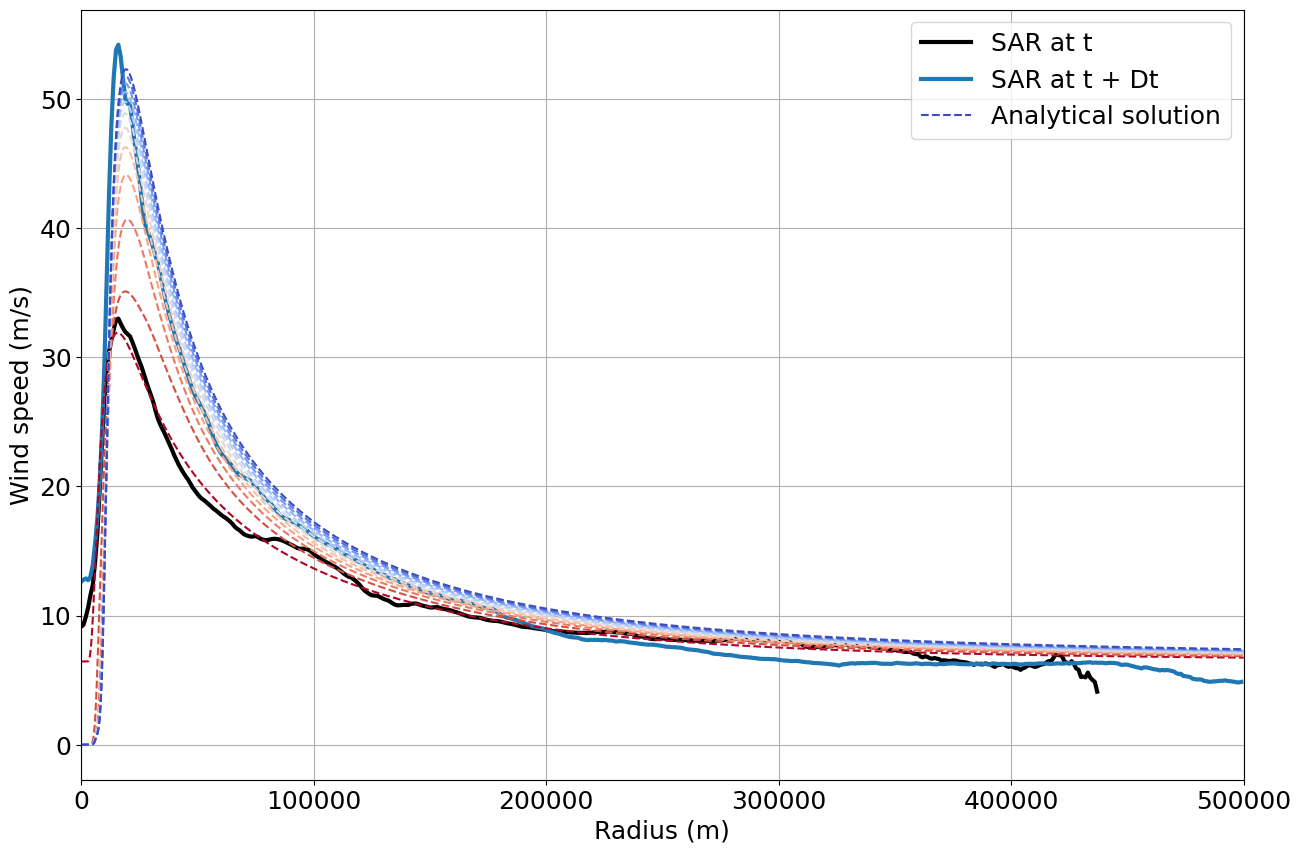

In [19]:
i       = 0
delta_h = 48
K       = 70

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/7 [00:00<?, ?it/s]

R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 41 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 41 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 43 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

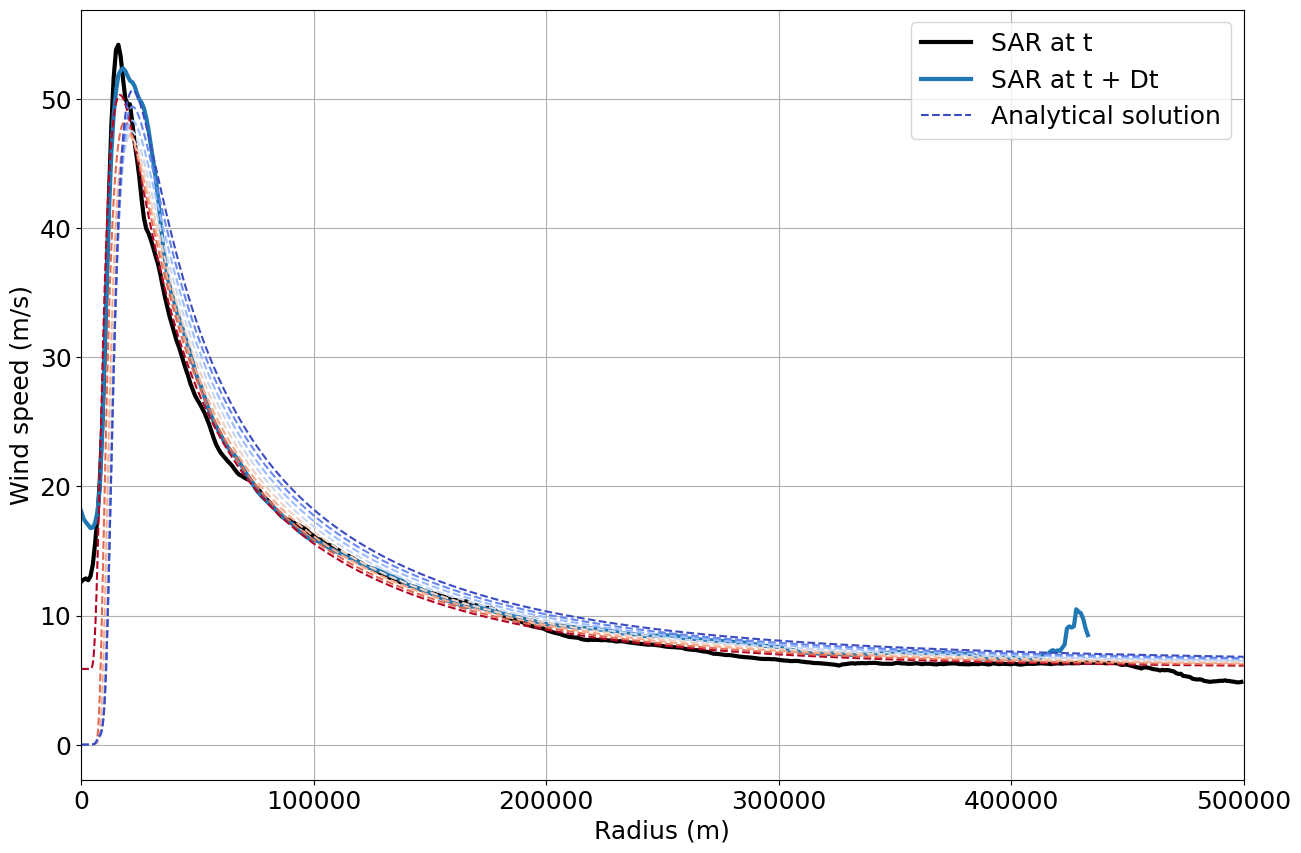

In [20]:
i       = 1
delta_h = 48
K       = 75

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/2 [00:00<?, ?it/s]

R+ = 38 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 39 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

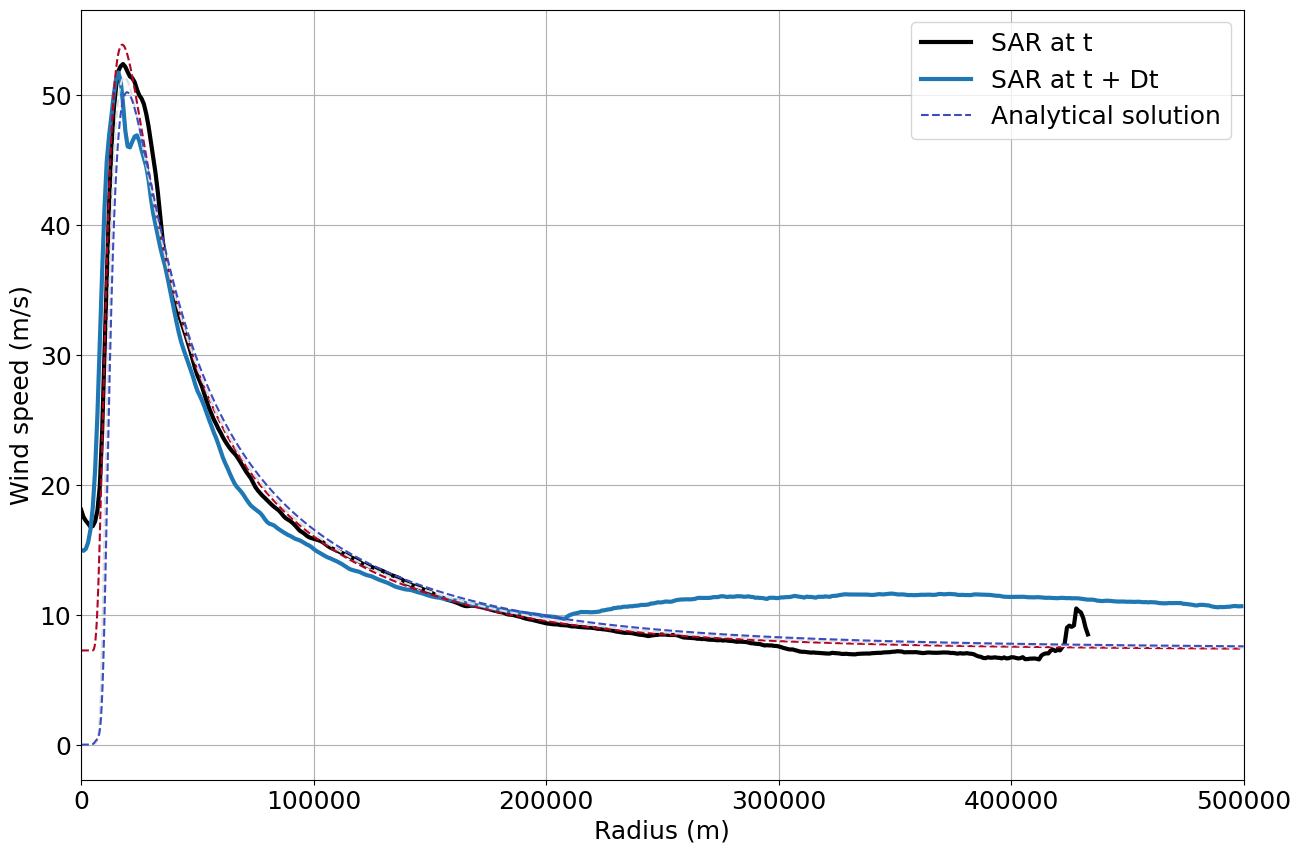

In [21]:
i       = 2
delta_h = 12
K       = 70

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/13 [00:00<?, ?it/s]

R+ = 37 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 38 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 39 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 41 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 41 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 42 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 43 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 43 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 44 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 44 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 45 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

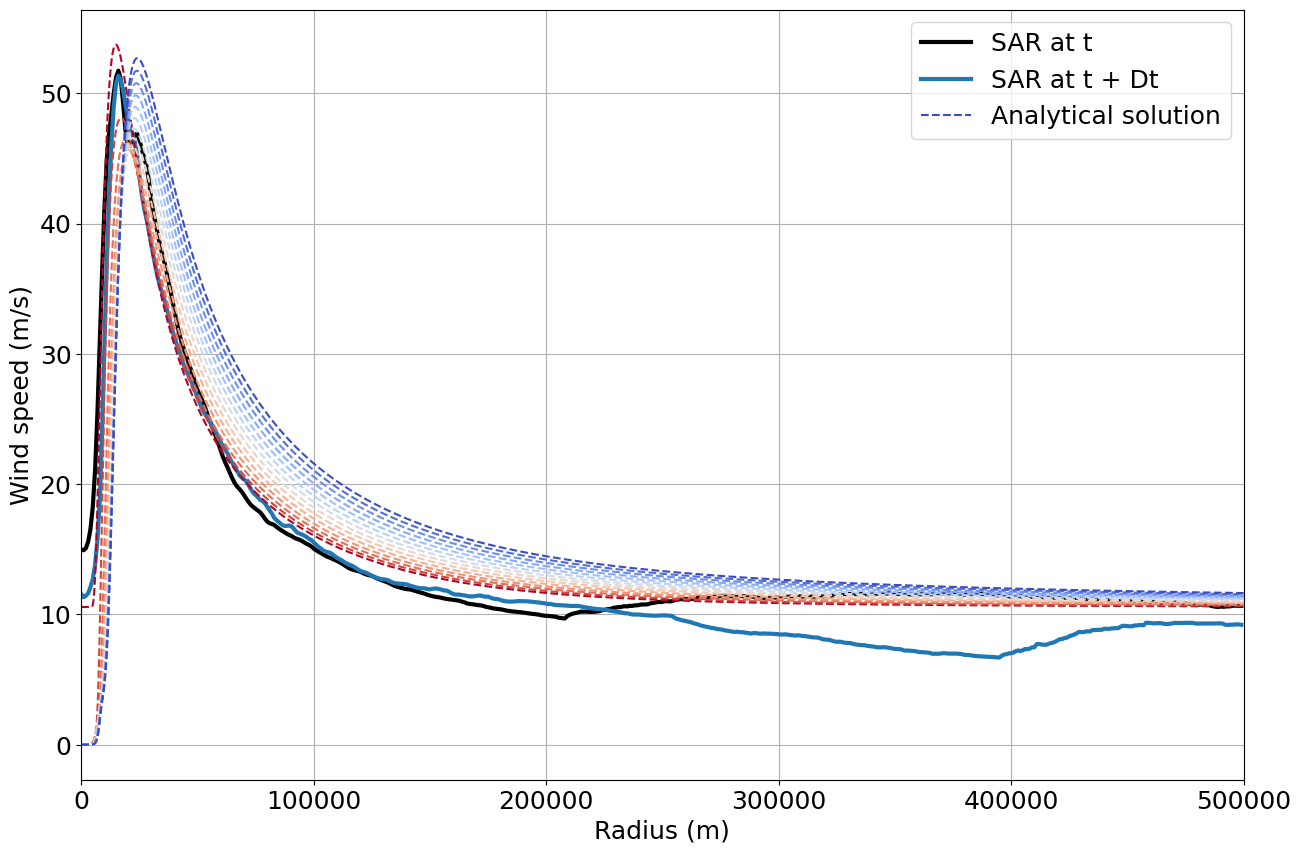

In [22]:
i       = 3
delta_h = 60
K       = 40

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/3 [00:00<?, ?it/s]

R+ = 37 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 39 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 40 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

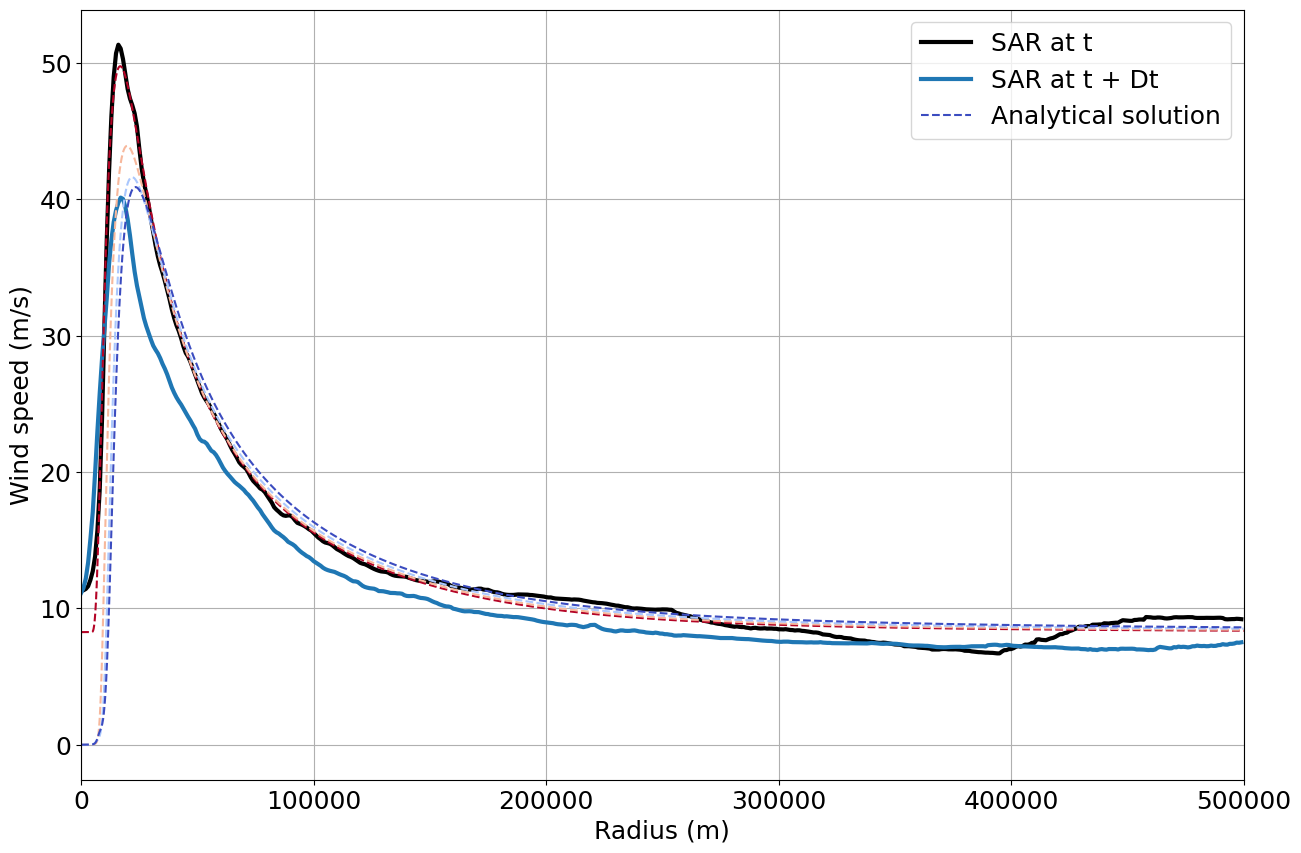

In [23]:
i       = 4
delta_h = 12
K       = 30

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

### Larry 2021

In [24]:
dsg.where(dsg.storm_name == 'LARRY', drop=True).sat_file.sortby('time')

<xarray.DataArray 'sat_file' (time: 5)>
array(['s1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc',
       'rs2--owi-cm-20210905t213342-20210905t213606-00003-1E37F_sw.nc',
       's1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc',
       'rs2--owi-cm-20210907t092755-20210907t093019-00003-1F5B6_sw.nc',
       's1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-04T08:52:27 ... 2021-09-07T21:48:17

Text(0.5, 1.0, 'LARRY')

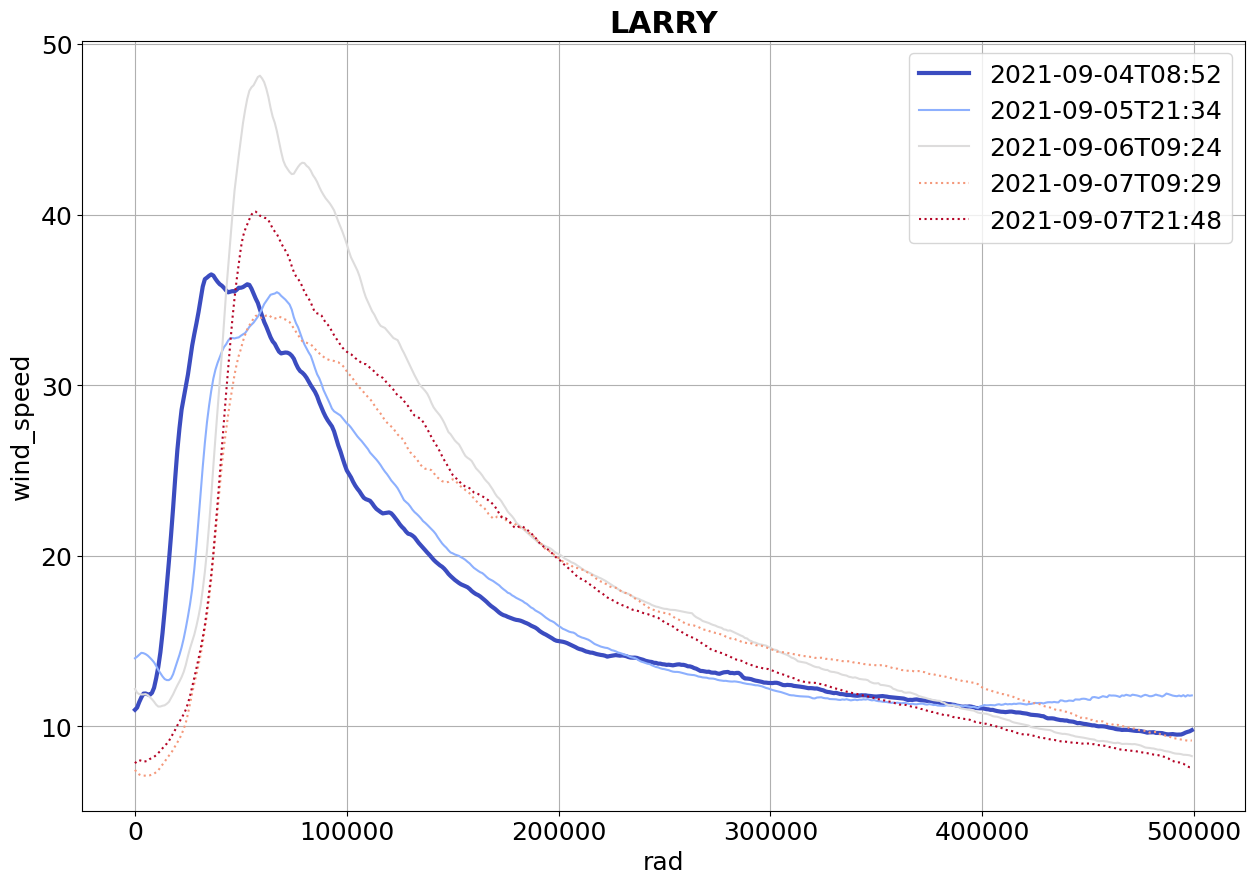

In [25]:
dsg.where(dsg.storm_name == 'LARRY', drop=True).B_hol

### LARRY
p1    = 's1b-ew-owi-ca-20210904t085102-20210904t085352-000003-036818_sw_al122021_cyclone.nc'
p2    = 'rs2--owi-ca-20210905t213342-20210905t213606-00003-1E37F_sw_al122021_cyclone.nc'
p3    = 's1a-ew-owi-ca-20210906t092329-20210906t092604-000003-04ACFC_sw_al122021_cyclone.nc'
p4    = 'rs2--owi-ca-20210907t092755-20210907t093019-00003-1F5B6_sw_al122021_cyclone.nc'
p5    = 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone.nc'

p1dsg = 's1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc'
p2dsg = 'rs2--owi-cm-20210905t213342-20210905t213606-00003-1E37F_sw.nc'
p3dsg = 's1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc'
p4dsg = 'rs2--owi-cm-20210907t092755-20210907t093019-00003-1F5B6_sw.nc'
p5dsg = 's1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('LARRY', weight='bold')

In [26]:
# rs = np.linspace(10, 1e6, 100001) # define dr accordingly
# rs = np.linspace(10, 500000, 50001) # define dr accordingly

# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))

  0%|          | 0/7 [00:00<?, ?it/s]

R+ = 72 km
R+ = 74 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 77 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 79 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 80 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 80 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 81 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

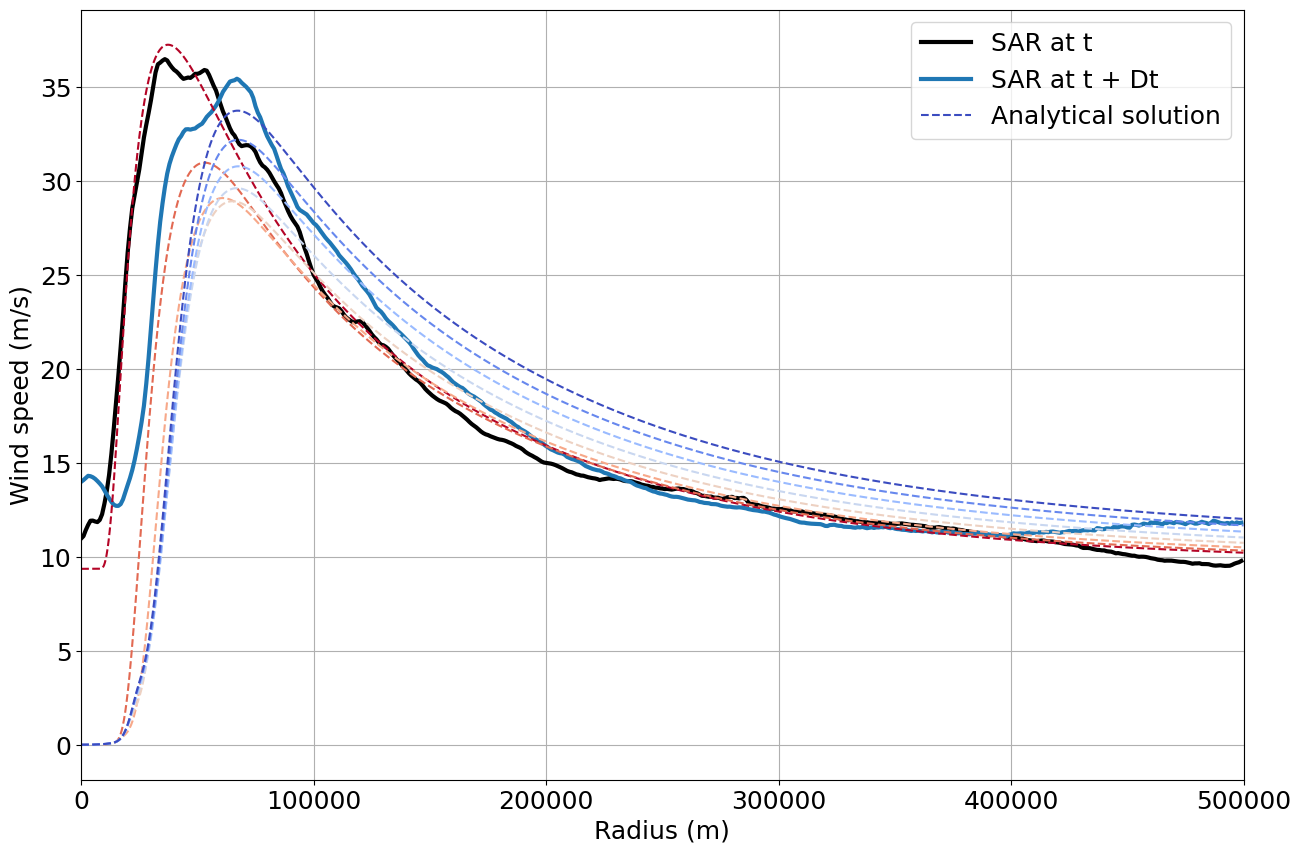

In [27]:
i       = 0
delta_h = 36
K       = 5

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/3 [00:00<?, ?it/s]

R+ = 72 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 67 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 67 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

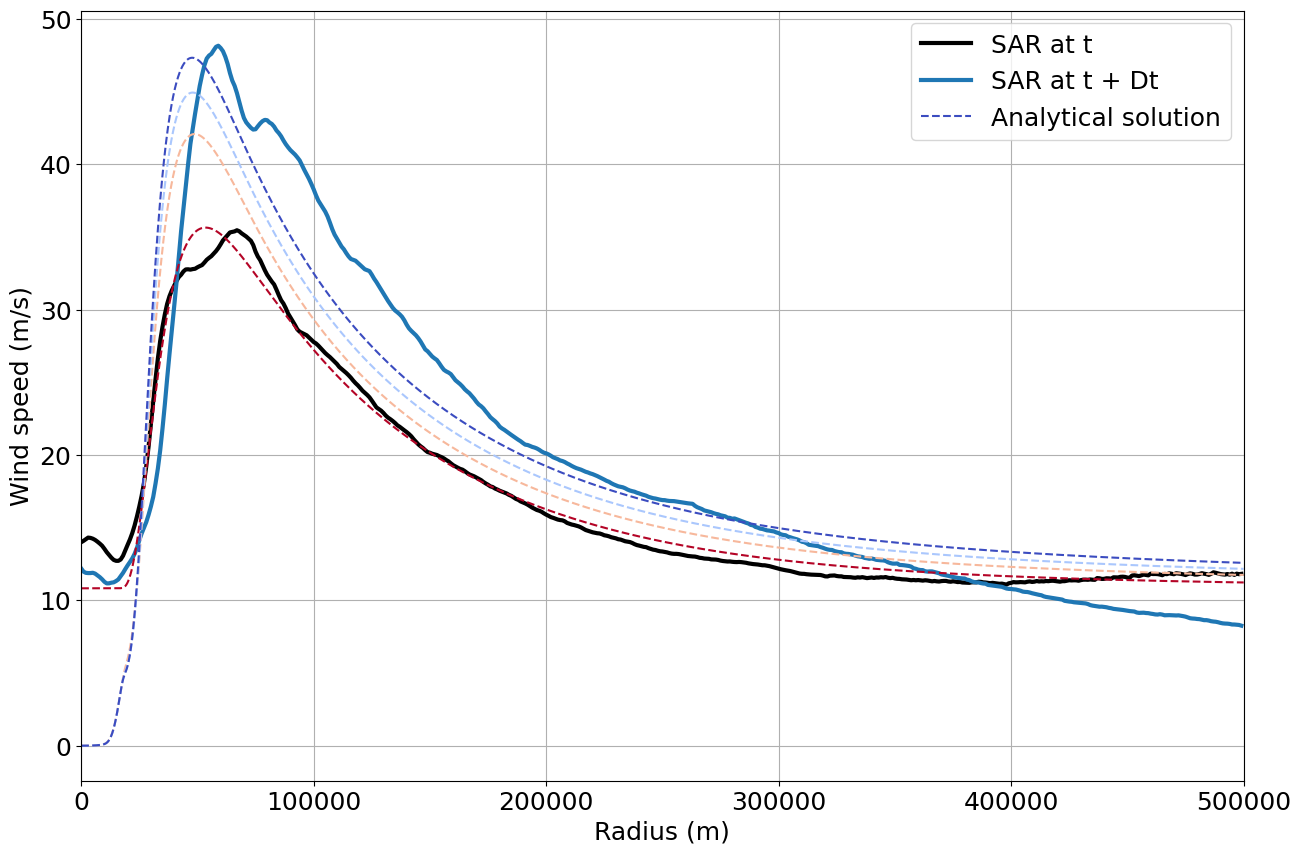

In [28]:
i       = 1
delta_h = 12
K       = 17

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/4 [00:00<?, ?it/s]

R+ = 81 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 94 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 102 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 104 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

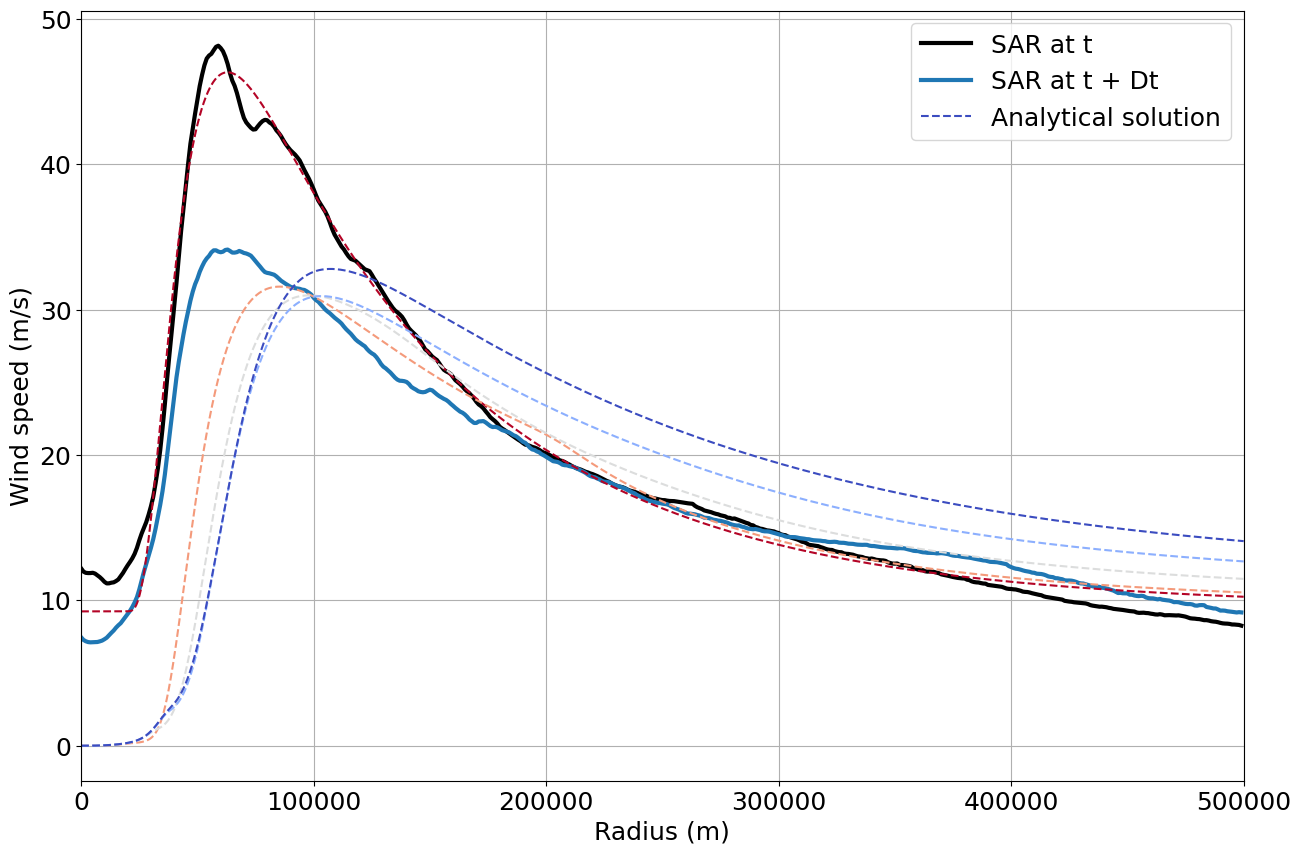

In [29]:
i       = 2
delta_h = 24
K       = 3

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)

  0%|          | 0/3 [00:00<?, ?it/s]

R+ = 84 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 82 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


R+ = 84 km


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


(0.0, 500000.0)

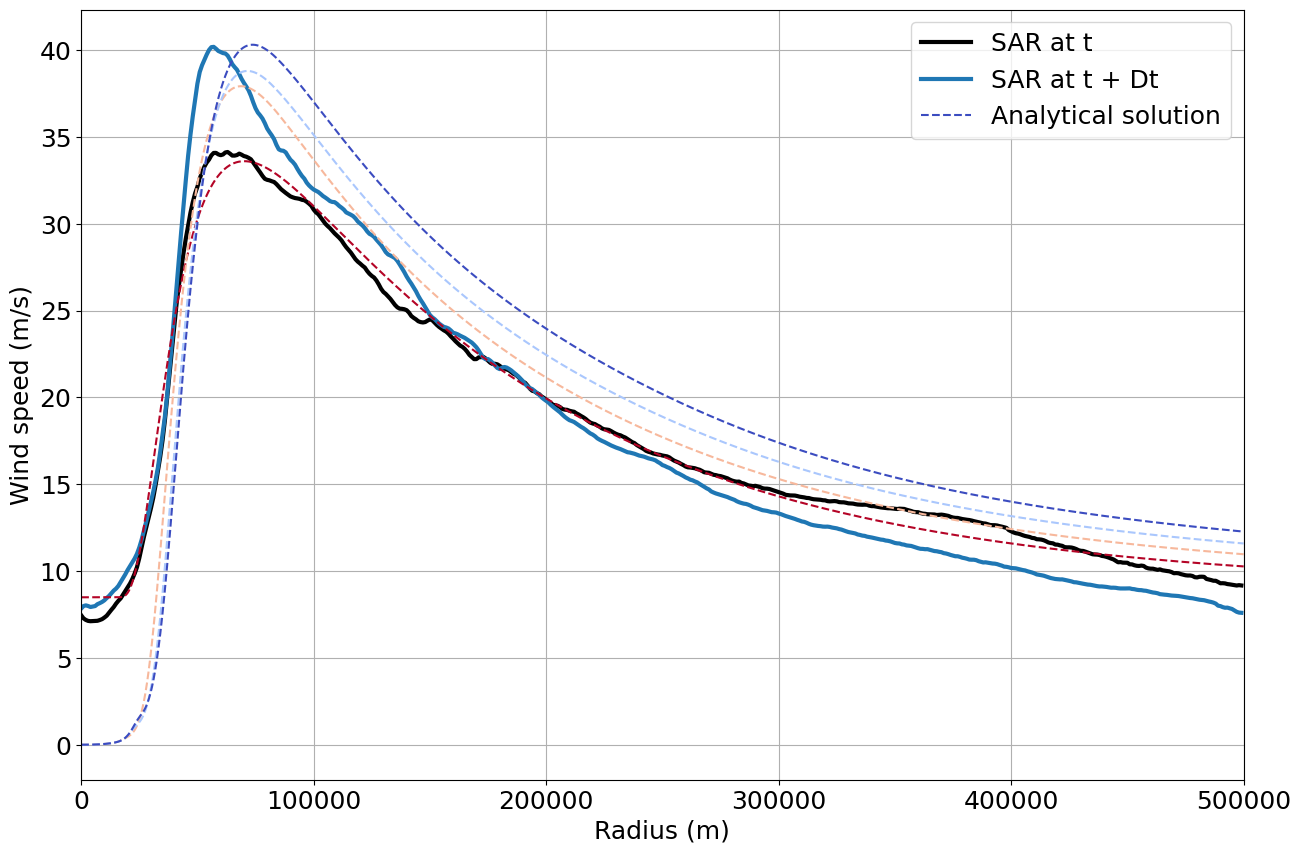

In [30]:
i       = 3
delta_h = 12
K       = 5

# Plot
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + Dt')

# Run model
interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend();plt.xlim(0, 0.5e6)